In [1]:
import pandas as pd
# from plotnine import *
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api

# import xgboost as xgb

# from statsforecast import StatsForecast
# from statsforecast.models import (
#     AutoARIMA,
#     HoltWinters,
#     AutoTheta,
#     AutoETS,
#     DynamicOptimizedTheta as DOT,
#     SeasonalNaive
# )


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

import pickle

In [2]:
tavg = pd.read_csv("new_england_tavg.csv", index_col=0, parse_dates=True).squeeze("columns")
tmax = pd.read_csv("new_england_tmax.csv", index_col=0, parse_dates=True).squeeze("columns")
tmin = pd.read_csv("new_england_tmin.csv", index_col=0, parse_dates=True).squeeze("columns")
season = pd.read_csv("tavg_season_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
trend = pd.read_csv("tavg_trend_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
resid = pd.read_csv("tavg_resid_new_england.csv", index_col=0, parse_dates=True).squeeze("columns")
prcp = pd.read_csv("new_england_prcp.csv", index_col=1, parse_dates=True)
prcp = prcp["measurement"].squeeze()
prcp

date
1951-01-01    0.33
1951-01-02    0.00
1951-01-03    0.22
1951-01-04    2.43
1951-01-05    1.05
              ... 
2021-12-27    0.08
2021-12-28    0.80
2021-12-29    1.97
2021-12-30    0.49
2021-12-31    0.59
Name: measurement, Length: 25933, dtype: float64

In [3]:
# by changing this you can change which data set you use in the following code
series = tavg
series

date
1951-01-01   -7.01
1951-01-02   -6.75
1951-01-03   -1.29
1951-01-04    4.18
1951-01-05   -0.57
              ... 
2021-12-27   -2.83
2021-12-28   -3.98
2021-12-29   -1.90
2021-12-30   -1.52
2021-12-31    0.49
Name: measurement, Length: 25933, dtype: float64

In the following code we shift the data set by one day and use todays temperature as our guess for tommorows temperature. This gives us a bench mark for our machine learning models to beat
the mae is mean absolute error, the mean difference between the prediction and the actual temp
The mean absolute error is only 2.3 for tavg, thus guessing the temp a day in advance based on todays temp is actually a pretty good starting point

In [4]:
# test how well prior day predicts temp
shifted = series.shift(1).fillna(0)

mae(tavg, shifted)

2.290050900397177

Now we try to get smart by adding a little momentum to the prediction. If we pay around it is possible to get an even better value, 2.27 but i don't really know what im doing here

In [5]:
# test how well prior day predicts temp
shifted = series.shift(1).fillna(0)
shifted2 = series.shift(2).fillna(0)
# shifted3 = series.shift(3).fillna(0)
# shifted4 = series.shift(4).fillna(0)
# shifted_min = tmin.shift(1).fillna(0)
# shifted_max = tmax.shift(1).fillna(0)

momentum = shifted - shifted2
x = shifted + (momentum*0.1)
z = shifted.rolling(3).mean().fillna(0)
y = (z+x)/2

mae(tavg, z)

2.900869676988136

We now do a lag plot to view the correlation between the temperature on one day vs one day ahead.
Clearly the correlation is very high
if you increase the lag it gets lower, but for tavg it stays strong for a very long time.
TIP: try setting a lag of 182, what do you notice?

In [6]:
series = resid

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

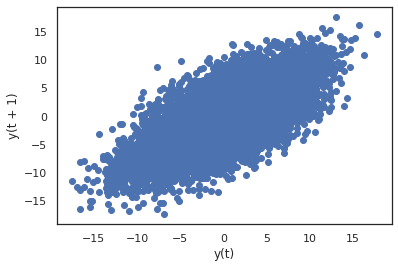

In [7]:
pd.plotting.lag_plot(series, lag=(1))


Lets create a correlation matrix to view the correlations between the tavg on a given day and a lag of 1, 7, 30, 182 0r 365 days

In [8]:
series = tavg

<AxesSubplot:>

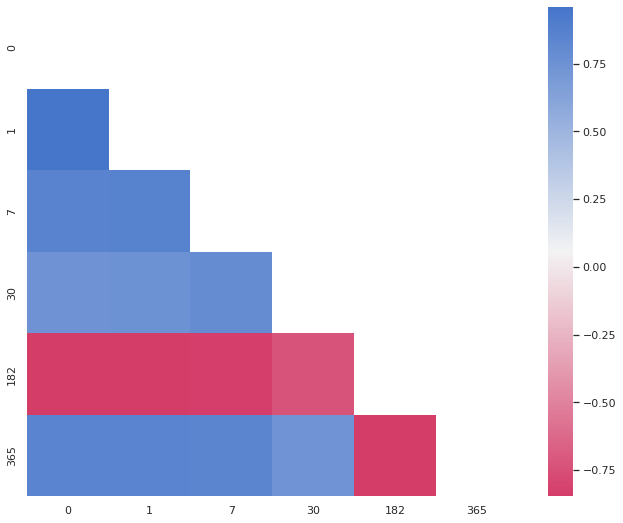

In [9]:
labels = [0,1,7,30,182,365]
correlation = pd.concat([series, series.shift(1), series.shift(7),series.shift(30),series.shift(182),series.shift(365)], axis=1)

correlation = correlation.corr(method = 'pearson')

plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(0, 255, sep=2, n=512, as_cmap=True)
sns.heatmap(correlation, mask=mask,cmap=cmap, xticklabels=labels, yticklabels=labels)

Now we plot auto correlation, which is the correlation between time t and a delayed version of itself.
In this case we plot the correlation between tavg and any point in time up to 1000 days in the past.
the light blue indicates statistical significance.

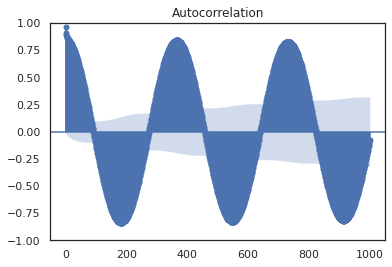

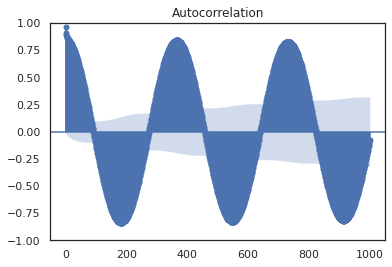

In [10]:
statsmodels.graphics.tsaplots.plot_acf(series, lags=np.arange(1,1000))

Now it's time to create a dataset with predictions, we start by using only the most recent data to predict the tavg a day or 2 in advance

In [11]:
# Copied from https://github.com/vcerqueira. this code allows us to create lags and a prediction horizon
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X




In [12]:
# applying time delay embedding
# exampl using 3 lags (n_lags=3) to predict the next value (horizon=1)
ts = time_delay_embedding(series=series, n_lags=30, horizon=3)
ts

,measurement(t-29),measurement(t-28),measurement(t-27),measurement(t-26),measurement(t-25),measurement(t-24),measurement(t-23),measurement(t-22),measurement(t-21),measurement(t-20),...,measurement(t-6),measurement(t-5),measurement(t-4),measurement(t-3),measurement(t-2),measurement(t-1),measurement(t-0),measurement(t+1),measurement(t+2),measurement(t+3)
date,,,,,,,,,,,,,,,,,,,,,
1951-01-31,-7.01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,...,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34
1951-02-01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,...,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93
1951-02-02,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,...,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93,-9.49
1951-02-03,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,...,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93,-9.49,-8.94
1951-02-04,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,-7.59,...,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93,-9.49,-8.94,-7.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-25,-1.43,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,...,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83
2021-12-26,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,...,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98
2021-12-27,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,-1.82,...,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11,-2.83,-3.98,-1.90


we split the columns that have a "+" in them, these are our target values 

In [13]:
# splitting target variable from explanatory variables
target_columns = ts.columns.str.contains('\+')
X = ts.iloc[:, ~target_columns]
y = ts[['measurement(t+1)','measurement(t+2)','measurement(t+3)' ]]
X

,measurement(t-29),measurement(t-28),measurement(t-27),measurement(t-26),measurement(t-25),measurement(t-24),measurement(t-23),measurement(t-22),measurement(t-21),measurement(t-20),...,measurement(t-9),measurement(t-8),measurement(t-7),measurement(t-6),measurement(t-5),measurement(t-4),measurement(t-3),measurement(t-2),measurement(t-1),measurement(t-0)
date,,,,,,,,,,,,,,,,,,,,,
1951-01-31,-7.01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,...,0.63,-8.11,-14.58,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32
1951-02-01,-6.75,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,...,-8.11,-14.58,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08
1951-02-02,-1.29,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,...,-14.58,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04
1951-02-03,4.18,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,...,-5.57,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34
1951-02-04,-0.57,-6.49,-7.24,-9.80,-11.71,-9.34,-6.10,-2.96,-3.86,-7.59,...,-0.32,-4.83,-7.77,-11.58,-10.14,-12.32,-19.08,-12.04,-3.34,-10.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-25,-1.43,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,...,-1.06,-0.93,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97
2021-12-26,2.33,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,...,-0.93,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30
2021-12-27,0.45,-4.00,-4.21,-4.47,-3.97,-1.11,1.97,-3.89,-4.76,-1.82,...,6.34,3.32,-2.09,-6.88,-6.86,-2.20,-3.30,-9.97,-8.30,-4.11


In [14]:
y

,measurement(t+1),measurement(t+2),measurement(t+3)
date,,,
1951-01-31,-19.08,-12.04,-3.34
1951-02-01,-12.04,-3.34,-10.93
1951-02-02,-3.34,-10.93,-9.49
1951-02-03,-10.93,-9.49,-8.94
1951-02-04,-9.49,-8.94,-7.71
...,...,...,...
2021-12-25,-8.30,-4.11,-2.83
2021-12-26,-4.11,-2.83,-3.98
2021-12-27,-2.83,-3.98,-1.90


Now time to split into train test

In [15]:

# train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.33, shuffle=False)


In [16]:
y_ts

,measurement(t+1),measurement(t+2),measurement(t+3)
date,,,
1998-08-05,19.84,20.85,21.17
1998-08-06,20.85,21.17,21.08
1998-08-07,21.17,21.08,22.45
1998-08-08,21.08,22.45,23.49
1998-08-09,22.45,23.49,23.81
...,...,...,...
2021-12-25,-8.30,-4.11,-2.83
2021-12-26,-4.11,-2.83,-3.98
2021-12-27,-2.83,-3.98,-1.90


In [18]:
#fitting a random forest
model = RandomForestRegressor(verbose=1)
model.fit(X_tr, y_tr)
model

RandomForestRegressor(verbose=1)

In [ ]:
# # load the model from disk
# model = pickle.load(open("random_forest_naive.sav", 'rb'))
# model

In [ ]:
# save the model to disk

# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))



In [20]:
# getting forecasts for the test set
predictions = model.predict(X_ts)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [21]:
predictions = pd.DataFrame(predictions, columns = ['one day','two days','three days'])
predictions

,one day,two days,three days
0,19.5052,19.2223,18.6541
1,19.7070,19.1507,18.7993
2,20.6232,19.7666,19.6100
3,20.6221,20.4135,20.1762
4,20.6122,20.0940,19.5886
...,...,...,...
8543,-8.8464,-7.6978,-6.6745
8544,-6.1666,-5.0480,-5.1902
8545,-2.8455,-2.9084,-2.8365
8546,-2.9441,-3.0746,-3.3126


In [39]:
y = y_ts["measurement(t+1)"].reset_index(drop=True)
x = predictions["one day"].reset_index(drop=True)

results_one_ahead = pd.concat([x, y],axis="columns")

2.130760294805803

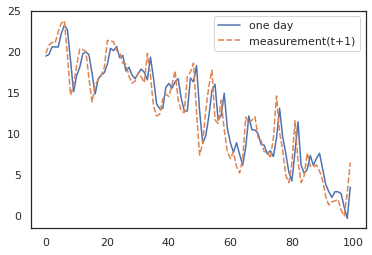

In [40]:
sns.lineplot(data=results_one_ahead[:100])
# computing MAE error
mae(y,x)

3.046068694431446

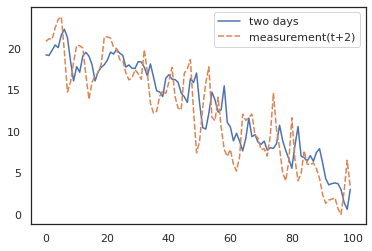

In [41]:
y = y_ts["measurement(t+2)"].reset_index(drop=True)
x = predictions["two days"].reset_index(drop=True)

results_one_ahead = pd.concat([x, y],axis="columns")
sns.lineplot(data=results_one_ahead[:100])
mae(y,x)

3.313129620963968

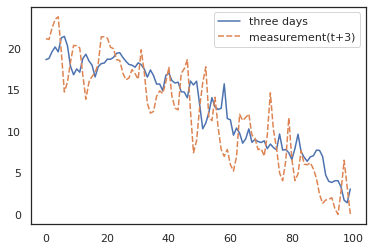

In [42]:
y = y_ts["measurement(t+3)"].reset_index(drop=True)
x = predictions["three days"].reset_index(drop=True)

results_one_ahead = pd.concat([x, y],axis="columns")
sns.lineplot(data=results_one_ahead[:100])
mae(y,x)